In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import splev
from sklearn.cluster import KMeans

np.random.seed(4449)

In [2]:
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Sales_Transactions_Dataset_Weekly.csv"
data = pd.read_csv(url).iloc[:, 1:53].values
mean = np.mean(data, axis=1, keepdims=True)
X_centered = data - mean
print(X_centered.shape)

(811, 52)


In [3]:
# converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3
    
    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0
            
        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
                    
            basis[oright, :] = xr @ tt
        
        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis

In [4]:
weeks = np.arange(1, 53, 1)
F = ns(weeks, df=10)
F_mean = F.mean(axis=0)
F_centered = F - F_mean
BT = np.linalg.inv(F_centered.T @ F_centered) @ F_centered.T @ X_centered.T
B = BT.T

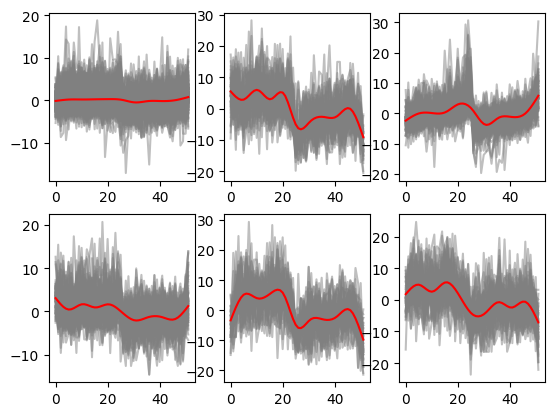

In [5]:
k = 6
kmeans_B = KMeans(n_clusters=k).fit(B)
labels_B = kmeans_B.labels_
cluster_centers_B = kmeans_B.cluster_centers_

fig, axes = plt.subplots(2, 3)
axes = axes.ravel()

for idx in range(k):
    cluster_idx = np.where(labels_B == idx)[0]
    centered_timeseries = X_centered[cluster_idx, :]

    for timeseries in centered_timeseries:
        axes[idx].plot(timeseries, color='grey', alpha=0.5)

    cluster_center = F_centered @ cluster_centers_B[idx]
    axes[idx].plot(cluster_center, color='red')

plt.show()

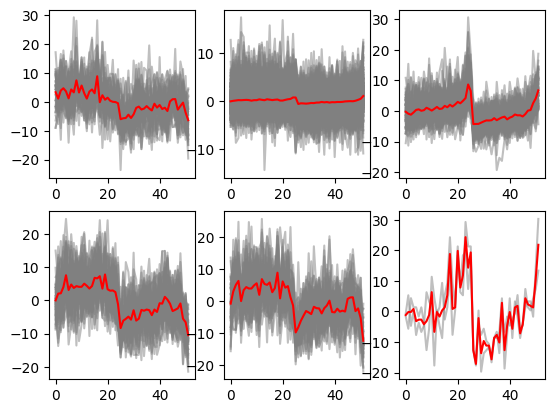

In [6]:
k = 6
kmeans_X = KMeans(n_clusters=k).fit(X_centered)
labels_X = kmeans_X.labels_
cluster_centers_X = kmeans_X.cluster_centers_

fig, axes = plt.subplots(2, 3)
axes = axes.ravel()

for idx in range(k):
    cluster_idx = np.where(labels_X == idx)[0]
    centered_timeseries = X_centered[cluster_idx, :]

    for timeseries in centered_timeseries:
        axes[idx].plot(timeseries, color='grey', alpha=0.5)

    cluster_center = cluster_centers_X[idx]
    axes[idx].plot(cluster_centers_X[idx], color='red')

plt.show()